In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.rcdefaults()

In [2]:
STRUCTURE_ID = "SLC25A17"
STRUCTURE_NAME = "peroxisome"
FOLDER_ID = "RS"
save_format = "svg"

In [3]:
base_folder = f"/allen/aics/animated-cell/Saurabh/cellpack-analysis/results/{STRUCTURE_ID}/{FOLDER_ID}/"

### load previously calculated correlations

Run `scripts/calculate_individual_PILR_correlations.sh` to calculate correlations

In [4]:
df = pd.read_csv(
    base_folder + "individual_PILR_corr.csv", index_col=[0, 1], header=[0, 1]
)

In [5]:
channels_to_use = [
    STRUCTURE_ID,
    "random",
    "nucleus_moderate",
    "membrane_moderate",
    # "planar_gradient_Z"
]

In [6]:
channel_name_dict = {
    STRUCTURE_ID: f"observed {STRUCTURE_NAME}",
    "random": "random",
    "nucleus_moderate": "nucleus",
    "membrane_moderate": "membrane",
    "planar_gradient_Z": "apical gradient"
}

In [7]:
color_dict = {
    "observed peroxisome": "green",
    "observed endosome": "gold",
    "random": "gray",
    "nucleus": "cyan",
    "membrane": "magenta",
    "apical gradient": "brown",
}

## create clustered heatmap with correlation values

In [8]:
df_subset = df.loc[channels_to_use, channels_to_use]
df_clean = df_subset.fillna(0)

### set save location

In [9]:
save_dir = Path(base_folder + "correlation_heatmap/")
save_dir.mkdir(parents=True, exist_ok=True)

### Get individual correlation distribution plots

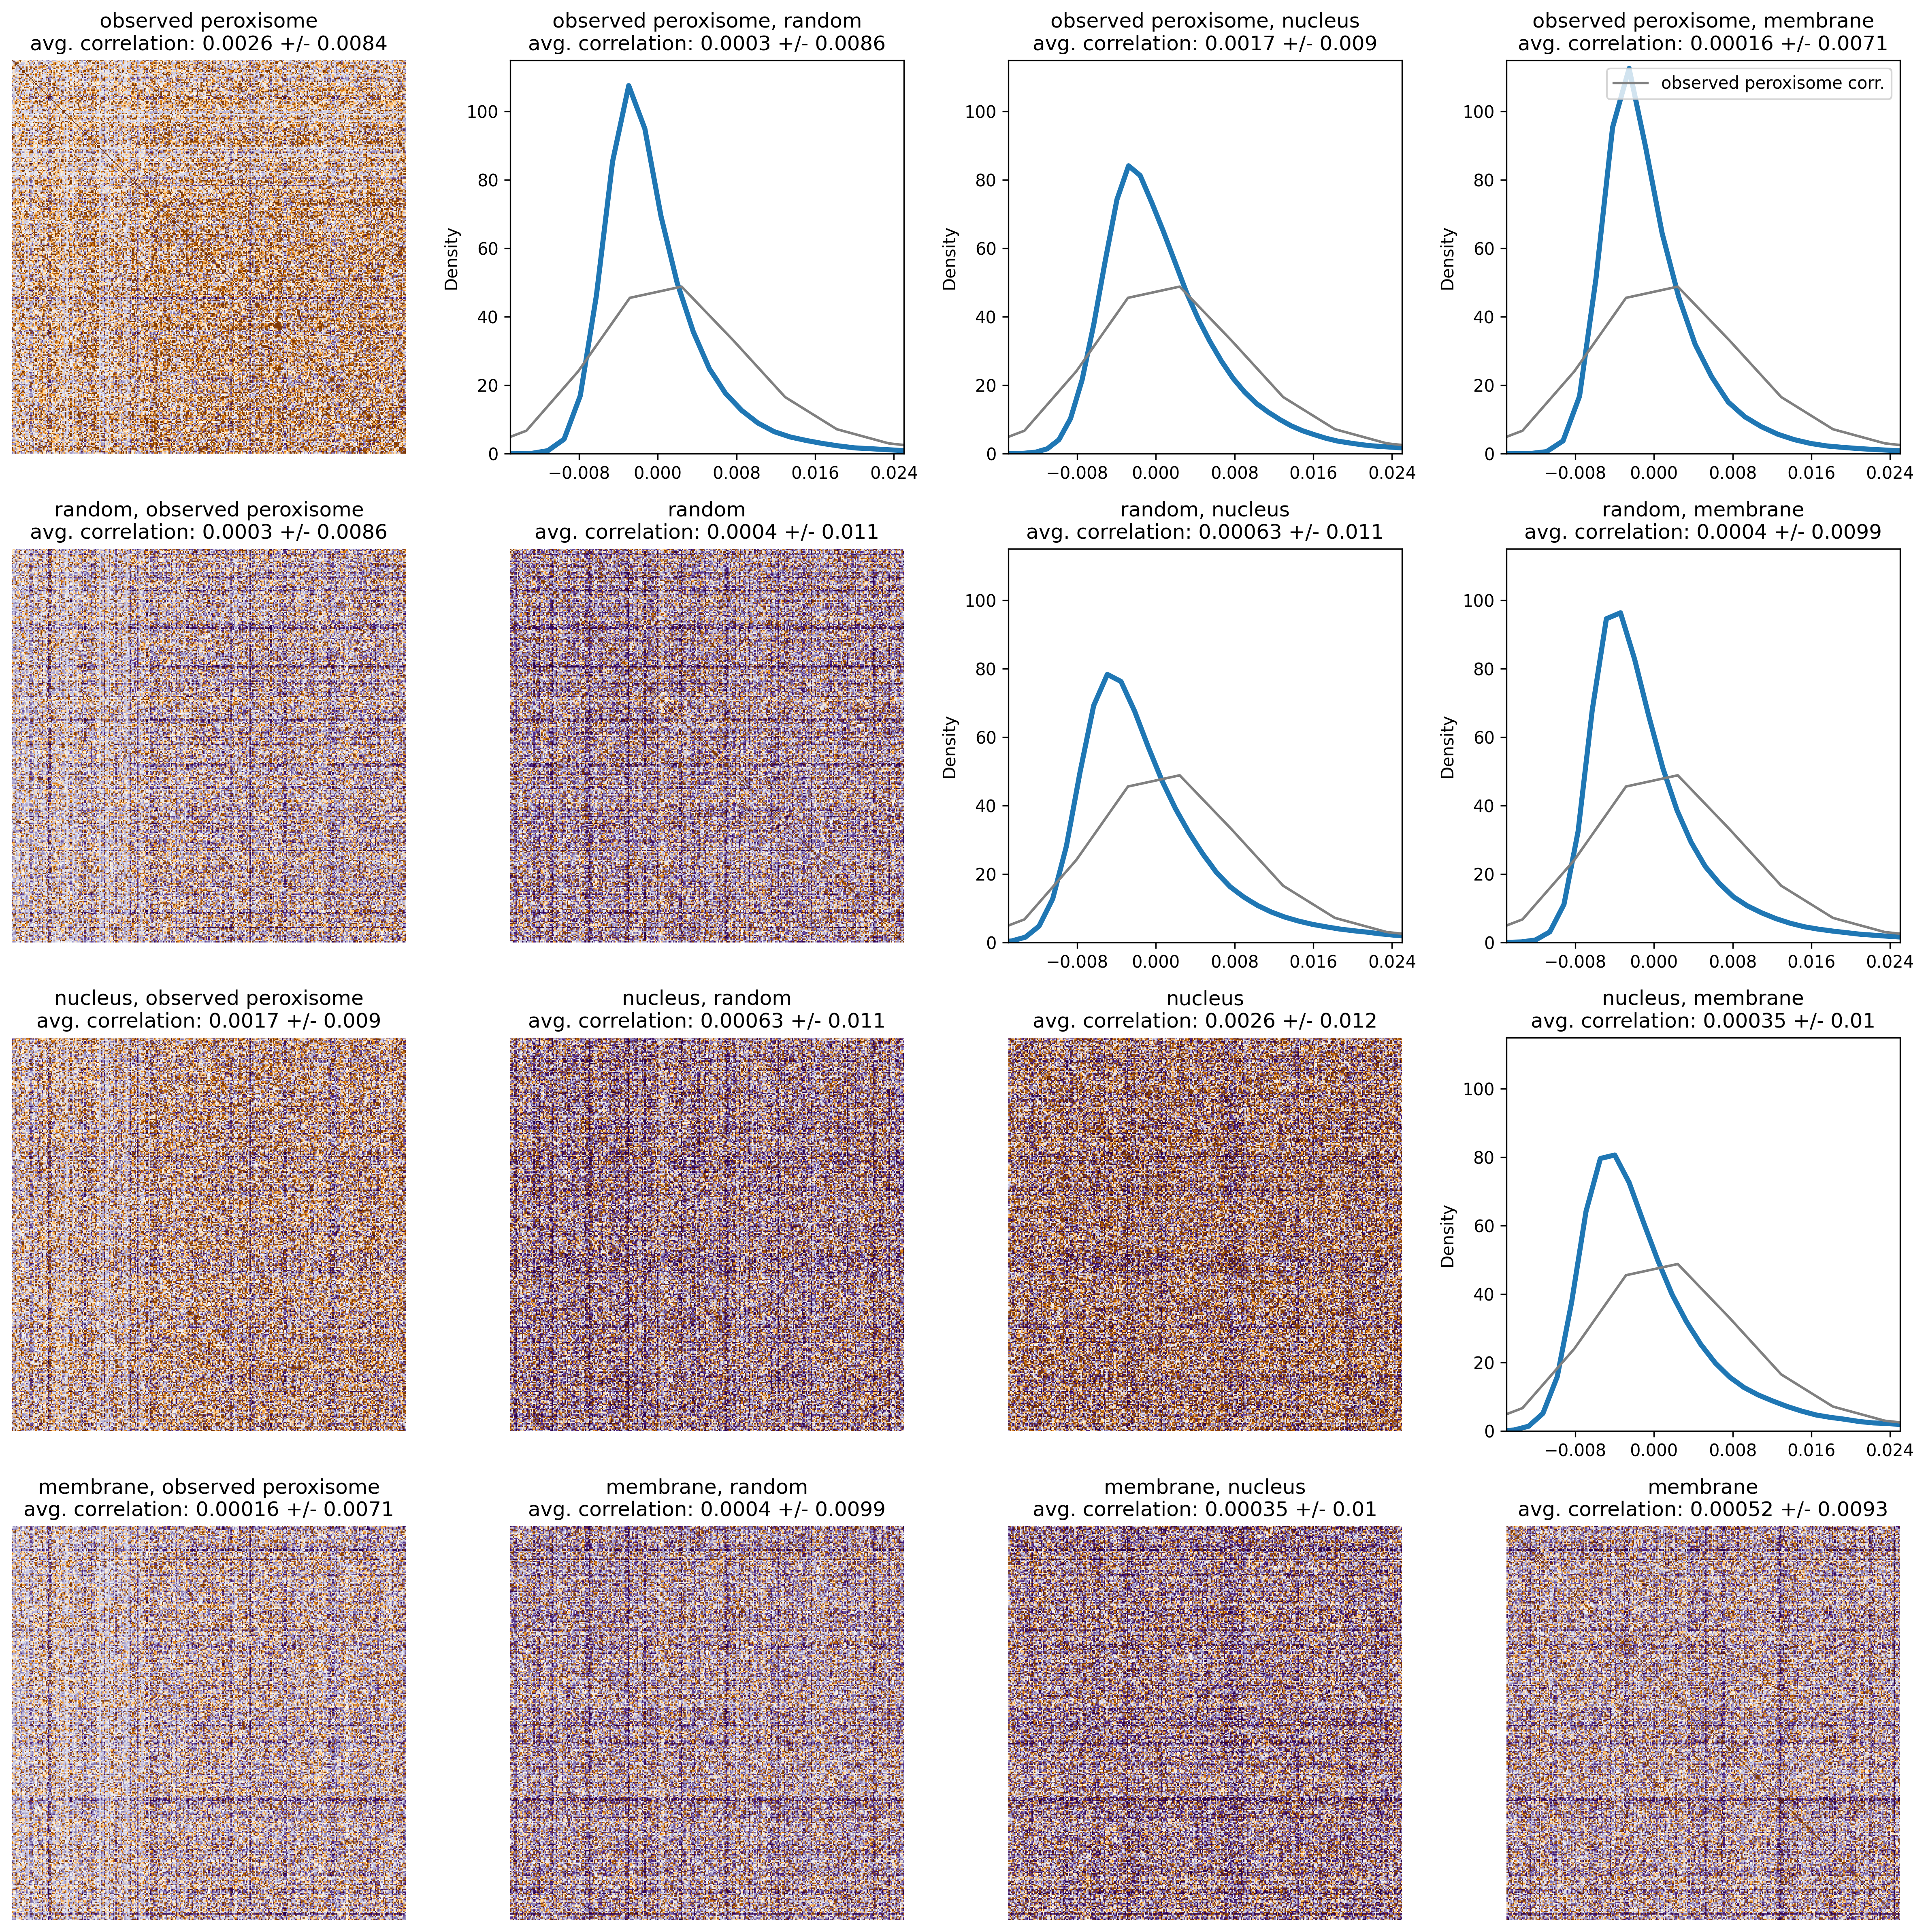

In [10]:
# get_upper diagonal values
plt.close("all")
num_channels = len(channels_to_use)
fig, axs = plt.subplots(nrows=num_channels, ncols=num_channels, figsize=(4 * num_channels, 4 * num_channels), dpi=300)
raw_corr_vals = df_clean.loc[STRUCTURE_ID, STRUCTURE_ID].values.flatten()
for ct, ch in enumerate(channels_to_use):
    for ct2, ch2 in enumerate(channels_to_use):
        ax = axs[ct, ct2]
        all_corr_vals = df_clean.loc[ch, ch2].values
        flat_corr_vals = all_corr_vals.flatten()
        cross_corr_vals = all_corr_vals[np.triu_indices(all_corr_vals.shape[0], k=1)]
        if ct >= ct2:
            ax.imshow(-all_corr_vals, cmap="PuOr", vmin=-0.008, vmax=0.008)
            ax.set_aspect("equal")
            ax.axis("off")
        else:
            mean_corr_val = np.mean(flat_corr_vals)
            std_corr_val = np.std(flat_corr_vals)
            axs[ct, ct2] = sns.kdeplot(
                flat_corr_vals,
                ax=ax,
                linewidth=3,
                # bw_adjust=1.5,
            )
            ax = axs[ct, ct2]
            axs[ct, ct2] = sns.kdeplot(
                raw_corr_vals,
                ax=ax,
                linewidth=1.5,
                color="gray",
                label=f"{channel_name_dict[STRUCTURE_ID]} corr.",
                # bw_adjust=1.5,
            )
            ax = axs[ct, ct2]
            # ax.axvline(mean_corr_val, color="red", linestyle="--", label=f"mean = {mean_corr_val:.3e}", alpha=0.5)
            # add shaded patch for std
            # ax.axvspan(mean_corr_val - std_corr_val, mean_corr_val + std_corr_val, alpha=0.2, color="red", label=f"std = {std_corr_val:.3e}")
            if ct == 0 and ct2 == axs.shape[1] - 1:
                ax.legend(loc="upper right")
            ax.set_ylabel("Density")
            ax.xaxis.set_major_locator(MaxNLocator(5))
            xlim =[-0.015, 0.025]
            ax.set_xlim(xlim)
            ymax = 115
            ax.set_ylim([0, ymax])
            ax.set_aspect((xlim[1] - xlim[0]) / ymax, adjustable='box')
        if ch == ch2:
            ax.set_title(
                f"{channel_name_dict[ch]}\navg. correlation: {np.mean(cross_corr_vals):.2g} +/- {np.std(cross_corr_vals):.2g}"
            )
        else:
            ax.set_title(f"{channel_name_dict[ch]}, {channel_name_dict[ch2]}\navg. correlation: {np.mean(flat_corr_vals):.2g} +/- {np.std(flat_corr_vals):.2g}")
# fig.supxlabel("Individual PILR Correlation")
plt.tight_layout()
plt.show()
fig.savefig(save_dir / f"individual_PILR_corr_hist_title.{save_format}", bbox_inches="tight", format=save_format, transparent=True, dpi=300)

### Create violin plots of individual correlation values

In [11]:
df_clean.loc[STRUCTURE_ID].shape

(305, 1220)

In [12]:
df_flat = pd.DataFrame(
    index=np.arange(df_clean.loc[STRUCTURE_ID].shape[0] ** 2),
    columns=[channel_name_dict[ch] for ch in channels_to_use],
)

In [13]:
for col in channels_to_use:
    all_corr_vals = df_clean.loc[STRUCTURE_ID, col].values
    col_name = channel_name_dict[col]
    if col==STRUCTURE_ID:
        cross_corr_vals = all_corr_vals[np.triu_indices(all_corr_vals.shape[0], k=1)]
        df_flat.loc[np.arange(len(cross_corr_vals)), col_name] = cross_corr_vals.flatten()
    else:
        df_flat[col_name] = all_corr_vals.flatten()

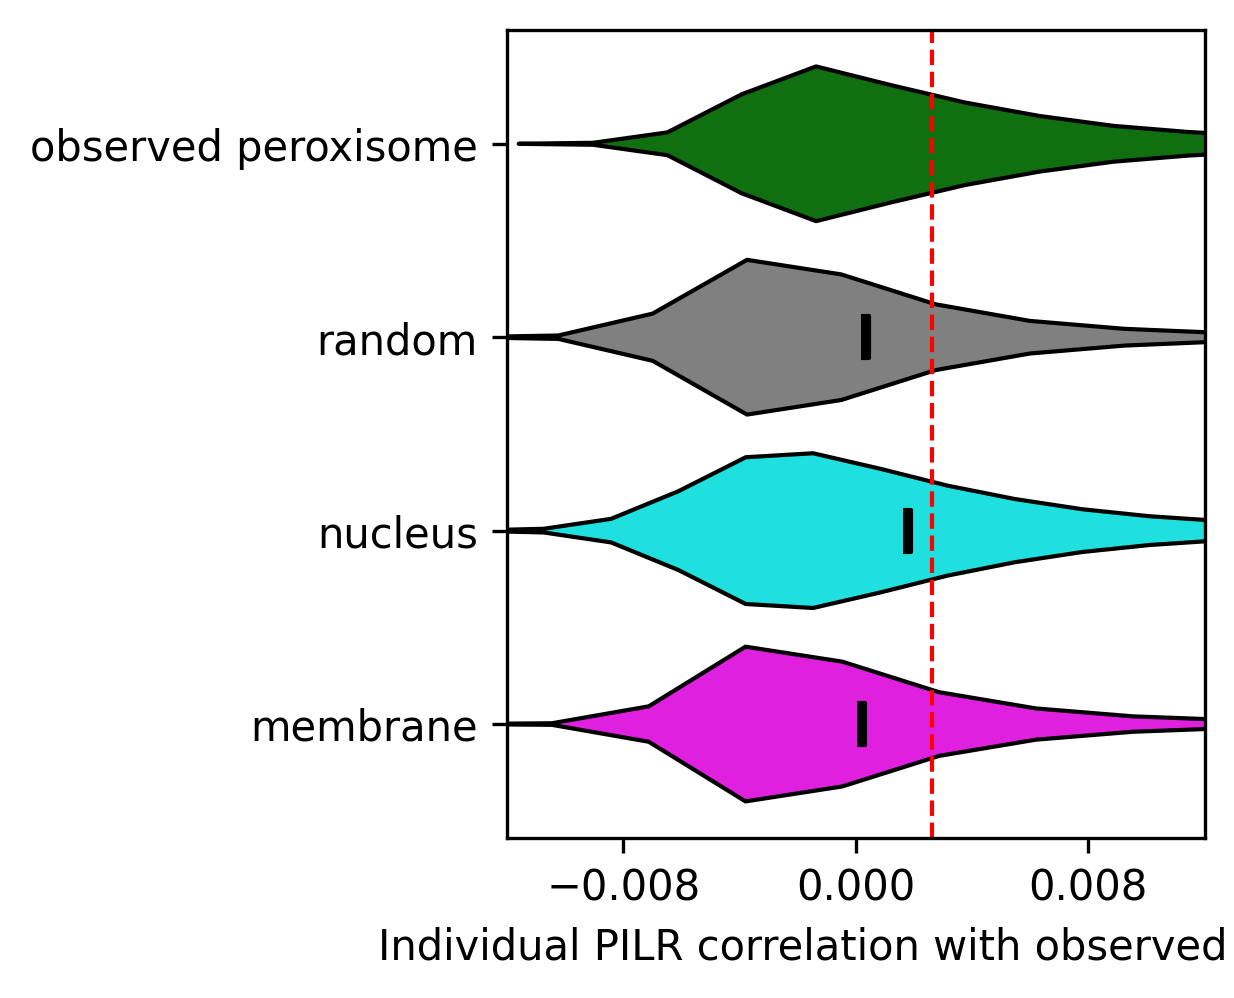

In [14]:
fig, ax = plt.subplots(figsize=(3, 3.5), dpi=300)
plt.rcParams.update({"font.size": 14})
ax = sns.violinplot(
    data=df_flat,
    orient="h",
    ax=ax,
    palette=color_dict,
    # bw_adjust=5,
    inner=None,
    cut=0,
    linewidth=1,
    linecolor="k",
    # inner_kws={
    #     "box_width": 8,
    #     "whis_width": 1,
    # },
)
ax.set_xlabel("Individual PILR correlation with observed data")
# ax.yaxis.set_ticks([])
ax.set_xlim([-0.012, 0.012])
for ct, col in enumerate(df_flat.columns):
    if col == channel_name_dict[STRUCTURE_ID]:
        continue
    ax.scatter(
        df_flat[col].mean(),
        ct,
        s=100,
        color="k",
        marker=[
            (-1, -5),
            (1, -5),
            (1, 5),
            (-1, 5),
        ],
    )
ax.axvline(df_flat[channel_name_dict[STRUCTURE_ID]].mean(), color="r", linestyle="--", linewidth=1)
ax.xaxis.set_major_locator(MaxNLocator(3))
fig.savefig(save_dir / f"individual_PILR_corr_violin.{save_format}", bbox_inches="tight", format=save_format, transparent=True, dpi=300)
plt.show()

### plot density of correlation values for each individual channel

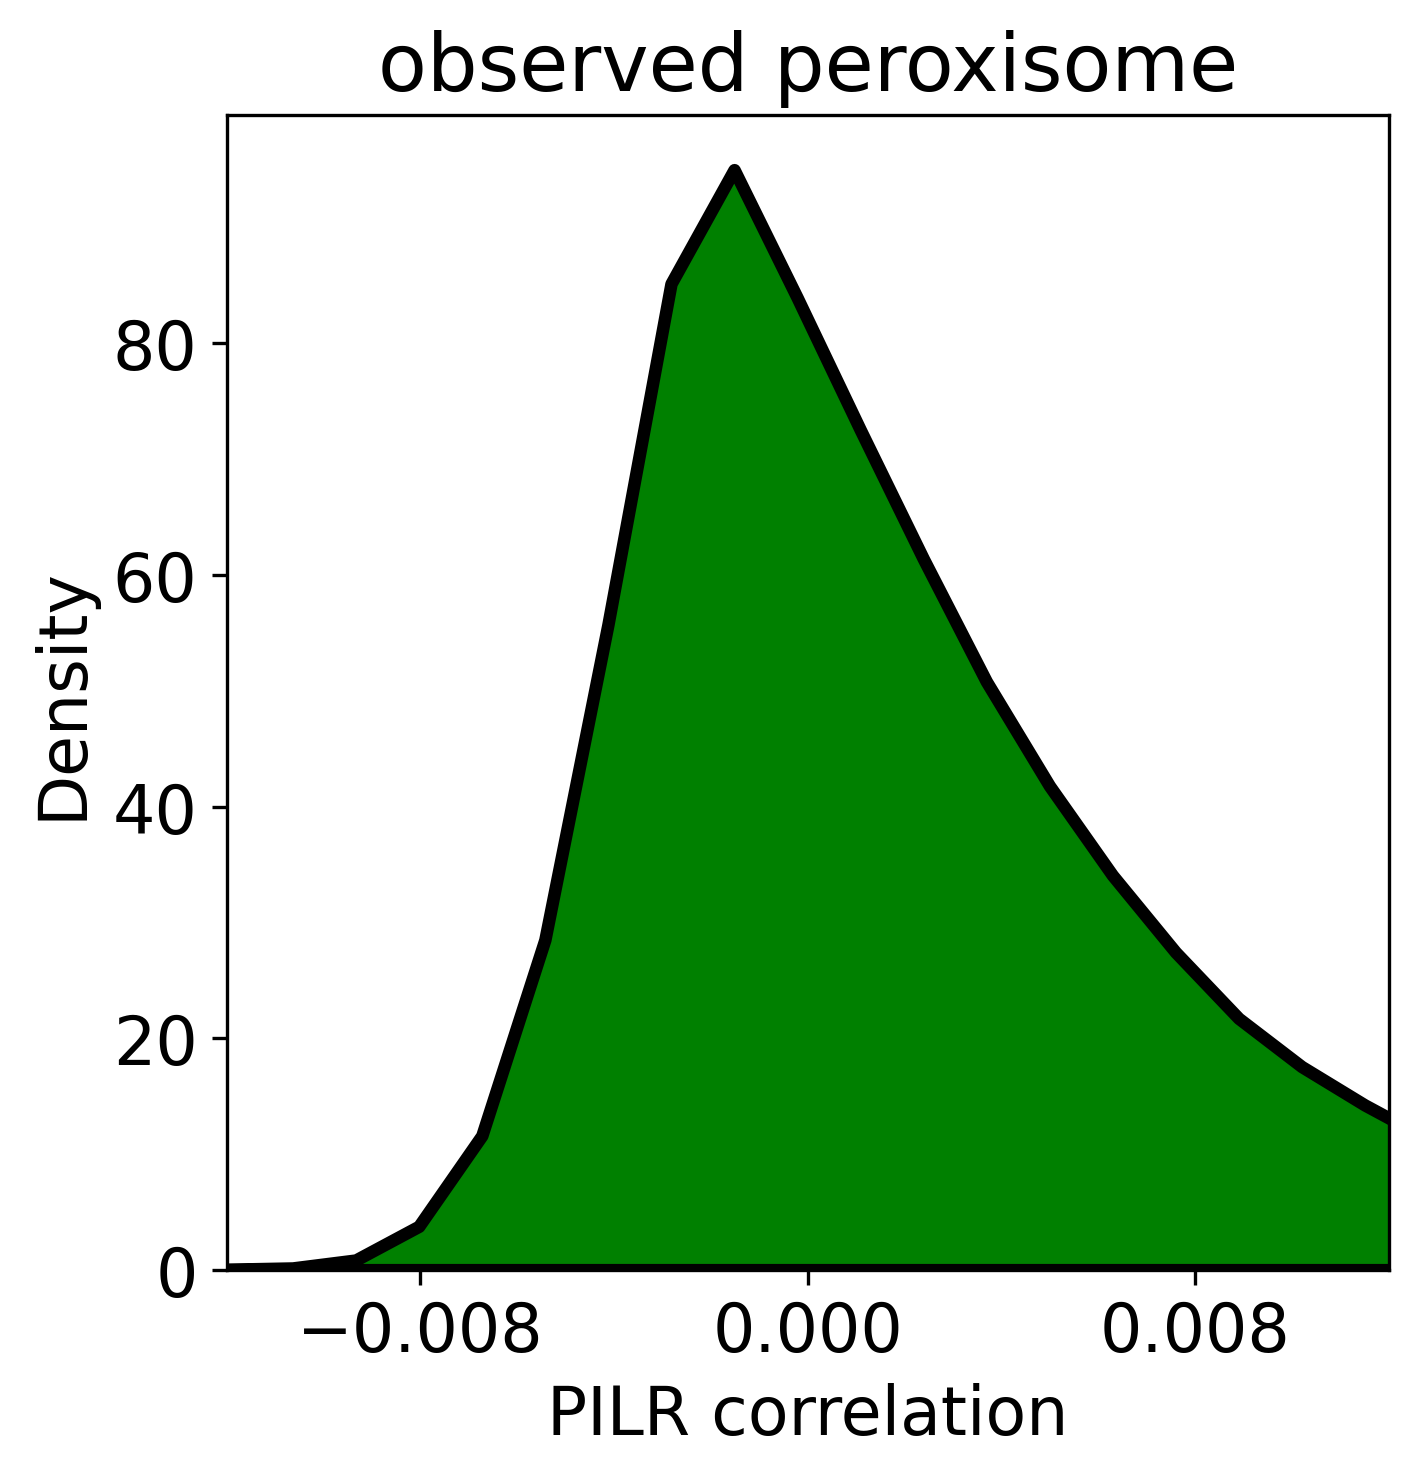

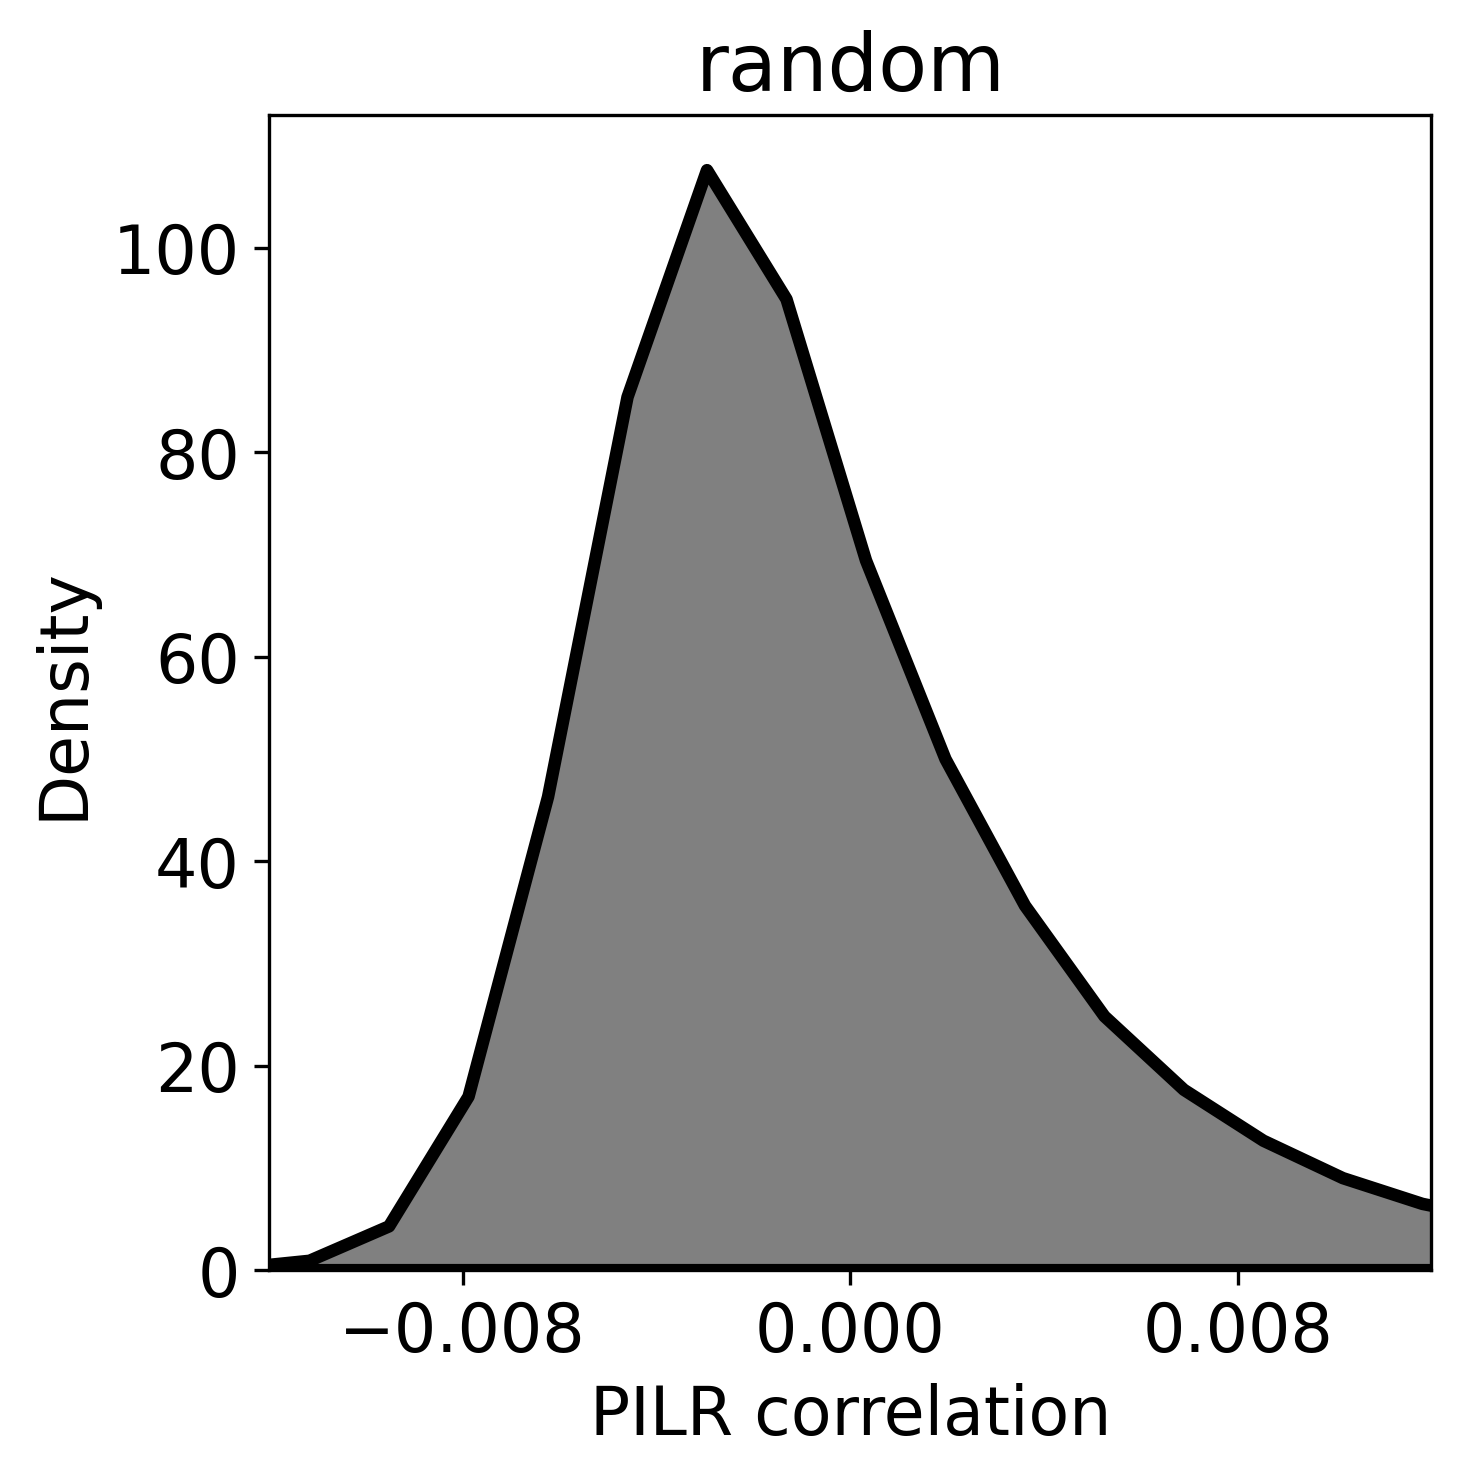

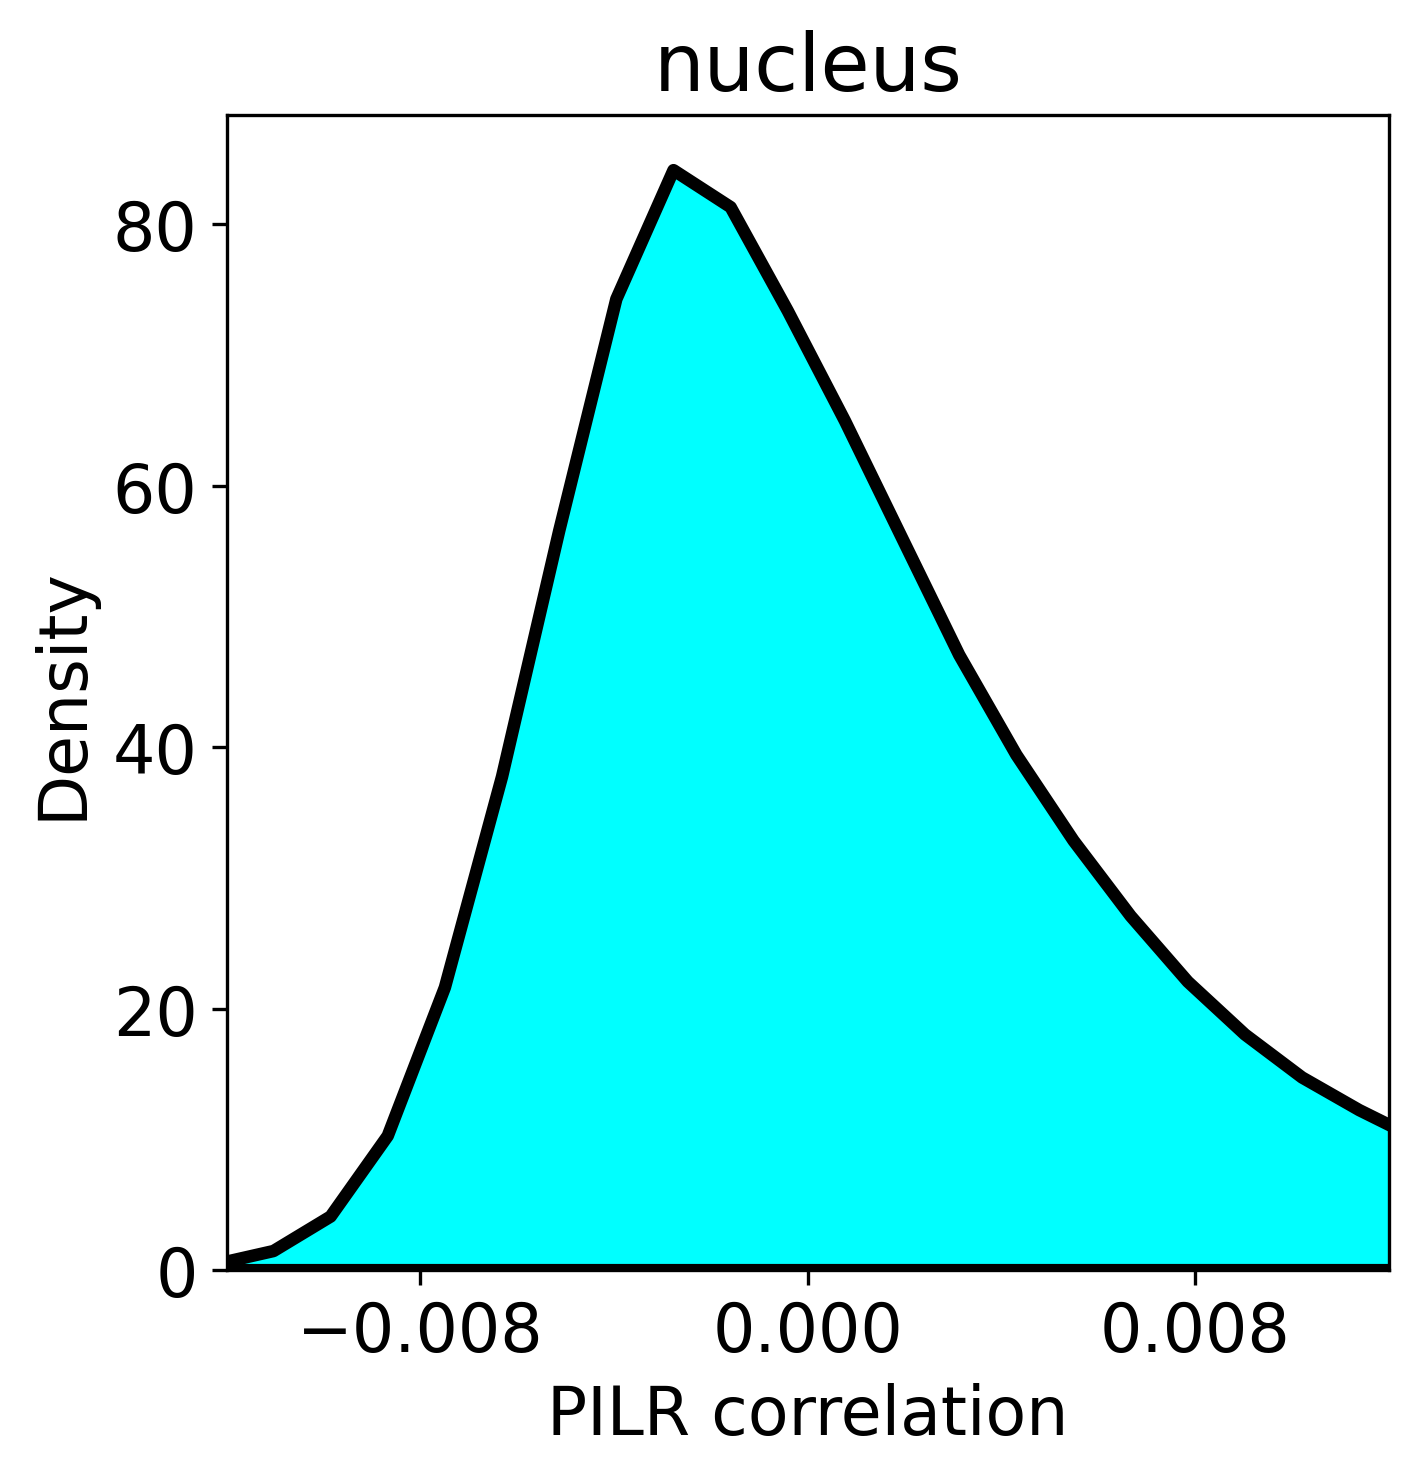

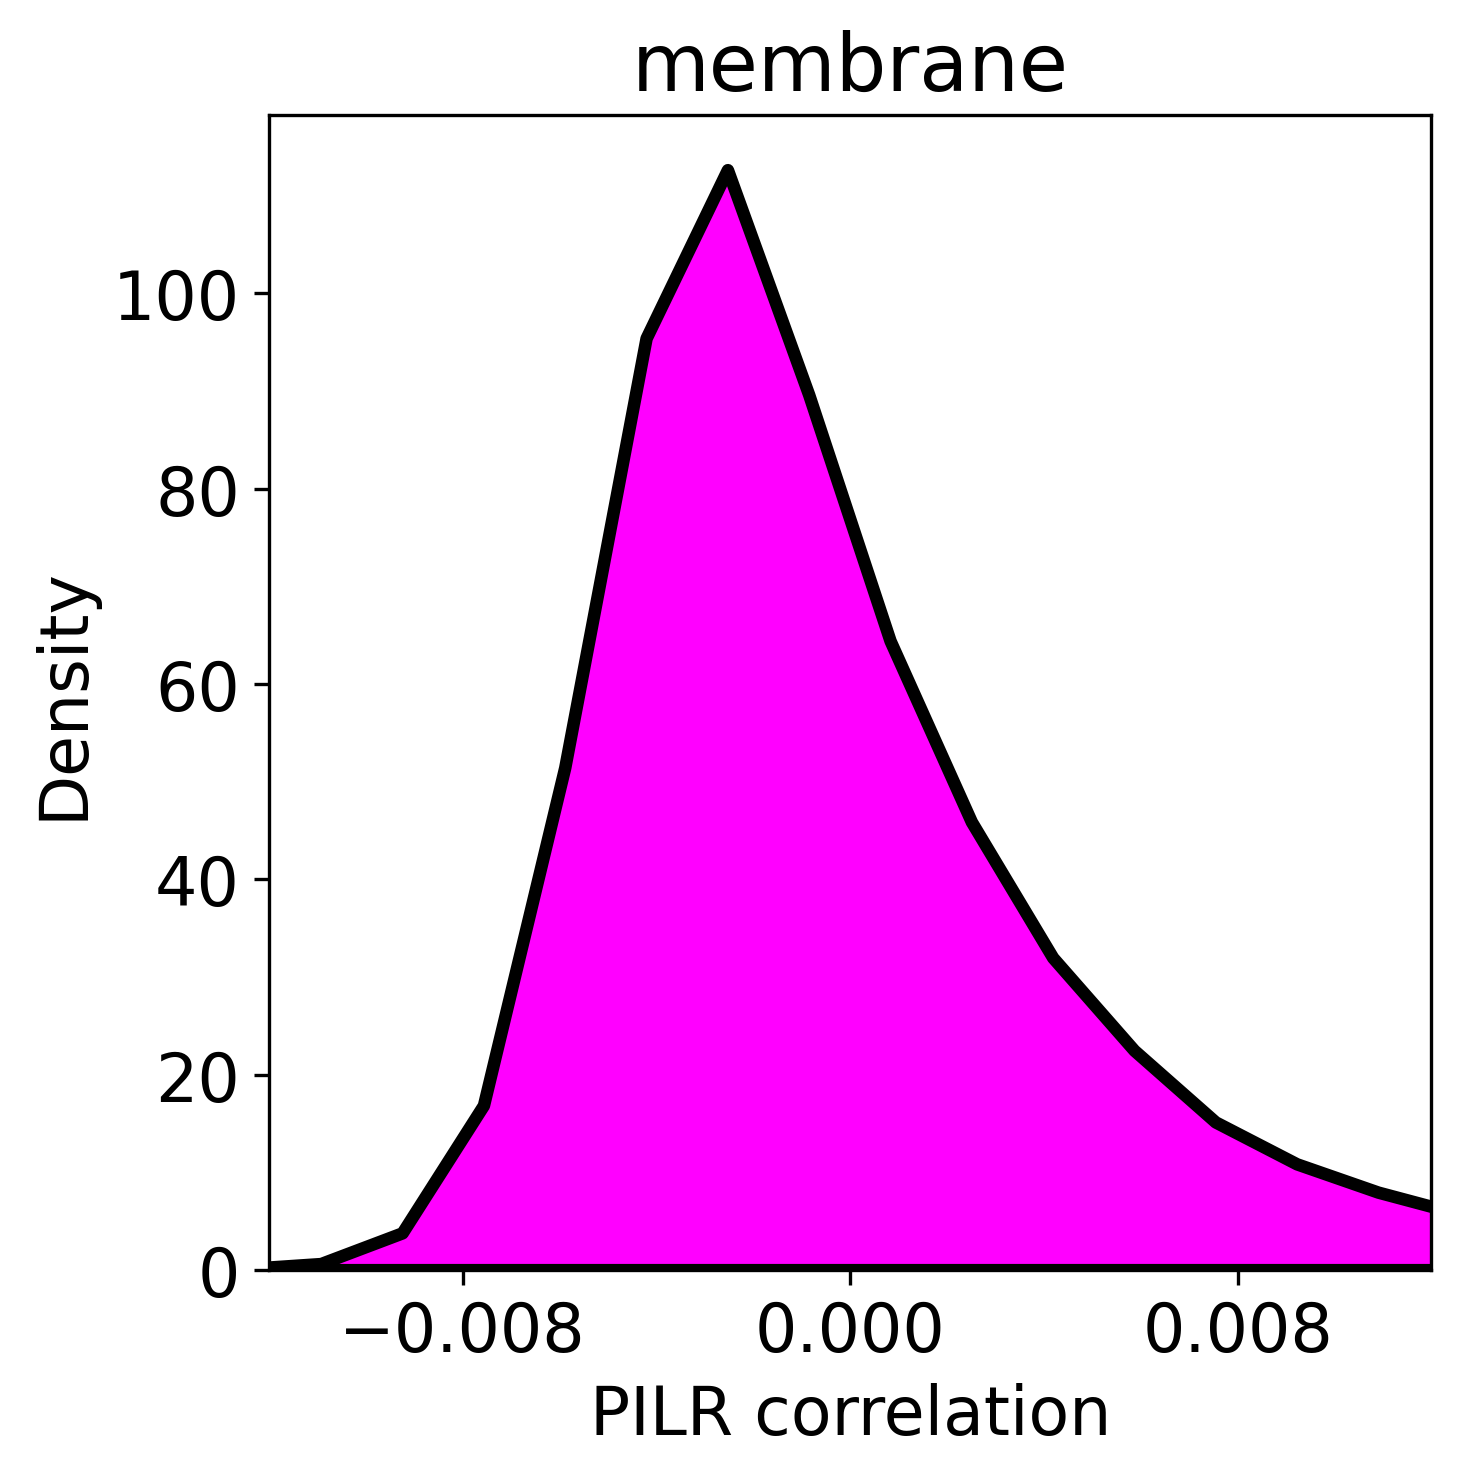

In [15]:
channel_hist_dir = save_dir / "channel_PILR_corr_hist"
channel_hist_dir.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({"font.size": 16})
for col in df_flat.columns:
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
    ax = sns.kdeplot(
        df_flat[col],
        linewidth=3,
        color=color_dict[col],
        edgecolor="k",
        fill=True,
        alpha=1,
        ax=ax,
    )
    ax.set_xlabel("PILR correlation")
    ax.set_ylabel("Density")
    ax.set_xlim([-0.012, 0.012])
    ax.set_xticks([-0.008, 0, 0.008])
    ax.set_title(col)
    fig.savefig(channel_hist_dir / f"{col}_PILR_corr_hist.{save_format}", bbox_inches="tight", format=save_format, transparent=True, dpi=300)
